In [1]:
# import rarfile
# rar_file_path = '/content/drive/MyDrive/Image Segmentation/LungImageXRAY.rar'
# # Define the folder where you want to extract the contents
# extracted_folder_path = '/content/drive/MyDrive/Image Segmentation/'

# with rarfile.RarFile(rar_file_path, 'r') as rar_ref:
#     rar_ref.extractall(extracted_folder_path)

:

    from glob import glob: Imports the glob function from the glob module. glob is used to find all pathnames matching a specified pattern according to the rules used by the Unix shell.

    from tqdm import tqdm: Imports the tqdm function from the tqdm module. tqdm provides a fast, extensible progress bar for loops and other iterable computations.

    from tensorflow.keras.utils import CustomObjectScope: Imports the CustomObjectScope class from the tensorflow.keras.utils module. It's used to temporarily add custom objects (like custom metrics or loss functions) to the Keras scope during model loading.

    from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten, Dense: Imports various layers used in building neural network models with Keras, such as convolutional layers (Conv2D), batch normalization (BatchNormalization), activation functions (Activation), max pooling (MaxPool2D), transposed convolutional layers (Conv2DTranspose), concatenation (Concatenate), input layer (Input), flatten layer (Flatten), and dense layer (Dense).

    from tensorflow.keras.metrics import Recall, Precision: Imports the Recall and Precision metrics from Keras. These are standard metrics used for evaluating classification models.

    from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau: Imports callbacks used during model training. ModelCheckpoint saves the model after every epoch, CSVLogger logs training data to a CSV file, and ReduceLROnPlateau reduces the learning rate when a metric has stopped improving.

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau


*  A convolutional block consists of two convolutional layers followed by batch normalization and ReLU activation functions. This block is a fundamental building block used in various parts of the neural network architecture.
Encoder Block

*  An encoder block is a combination of a convolutional block followed by max-pooling. This block is responsible for downsampling the spatial dimensions of the input, capturing hierarchical features.
Decoder Block

*  A decoder block involves the use of transposed convolutional layers (also known as fractionally strided convolutions) to upsample the input. Skip connections are incorporated by concatenating features from the corresponding encoder block. The decoder block helps in regaining spatial resolution.

In [3]:
# Define functions
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

U-Net Architecture

*  The U-Net architecture is a popular neural network design for image segmentation tasks. It is widely used in medical image analysis, particularly for tasks such as identifying and segmenting specific structures within an image.
Architecture Overview

*  The U-Net architecture consists of a contracting path followed by an expansive path, forming a U-shaped structure. Here's a brief overview of the main components:
Contracting Path

    Encoder Blocks: Initial convolutional blocks with downsampling to capture hierarchical features.

    Skip Connections: Connections between corresponding encoder and decoder blocks to preserve spatial information.

Bottleneck

    Bottleneck Block: A central block that captures the most abstract features.

Expansive Path

    Decoder Blocks: Blocks with upsampling to reconstruct the segmented output.

Output Layer

    Output Convolution: The final convolutional layer with a sigmoid activation function for binary segmentation.

Key Concepts

    Encoder Blocks: Responsible for extracting features through convolutional operations.

    Skip Connections: Facilitate the flow of high-resolution information from the contracting path to the expansive path.

    Bottleneck Block: Captures the most abstract features of the input data.

    Decoder Blocks: Upsample and reconstruct the segmented output.

    Sigmoid Activation: Applied to the output layer for binary segmentation tasks.

In [4]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

This function checks if a directory specified by the 'path' variable exists. If it doesn't exist, the function creates the directory along with any necessary parent directories.

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

`load_data` takes a path to a dataset containing chest X-ray images and corresponding manual masks. It splits the data into training, validation, and test sets for both images and masks. It uses the `train_test_split` function to achieve this, with a specified split ratio (default is 0.1) for validation and test sets. The function returns three tuples: training data (images and corresponding left and right masks), validation data, and test data.

The `read_image` function reads and preprocesses a color image by resizing it to a specified width and height, normalizing pixel values, and converting it to a float32 format. The `read_mask` function reads and preprocesses two grayscale images, combines them, resizes the result, normalizes pixel values, converts to a binary mask, and adds a singleton channel dimension.

In [6]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "CXR_png", "*.png")))
    masks1 = sorted(glob(os.path.join(path, "ManualMask", "leftMask", "*.png")))
    masks2 = sorted(glob(os.path.join(path, "ManualMask", "rightMask", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y1, valid_y1 = train_test_split(masks1, test_size=split_size, random_state=42)
    train_y2, valid_y2 = train_test_split(masks2, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y1, test_y1 = train_test_split(train_y1, test_size=split_size, random_state=42)
    train_y2, test_y2 = train_test_split(train_y2, test_size=split_size, random_state=42)

    return (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path1, path2):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 + x2
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

TensorFlow function `tf_parse` for parsing input data (images and masks). The inner function `_parse` decodes input strings, reads an image using read_image, and creates a mask using read_mask. The outer function uses tf.numpy_function to apply `_parse` to TensorFlow tensors and sets their shapes. The resulting parsed data consists of an image tensor with shape [H, W, 3] and a mask tensor with shape [H, W, 1].

>  A tensor is a mathematical object that generalizes the concept of scalars, vectors, and matrices. It is a multi-dimensional array of numerical values and serves as a fundamental data structure in various mathematical and scientific disciplines, particularly in the field of machine learning and deep learning. Tensors can have any number of dimensions, including zero (scalar), one (vector), two (matrix), and higher dimensions. They are used to represent and manipulate data in a way that facilitates mathematical operations and computations.

In [7]:
def tf_parse(x, y1, y2):
    def _parse(x, y1, y2):
        x = x.decode()
        y1 = y1.decode()
        y2 = y2.decode()

        x = read_image(x)
        y = read_mask(y1, y2)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y1, y2], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

TensorFlow dataset from input tensors X, Y1, and Y2. It shuffles the data, applies a parsing function (assumed to be defined elsewhere as tf_parse), batches the data with a specified batch size, and prefetches batches for improved performance during training.

In [8]:
def tf_dataset(X, Y1, Y2, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1, Y2))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

The code *snippet* sets random seeds for NumPy and TensorFlow to ensure reproducibility. It creates a directory called "files" for storing output files. Defines hyperparameters such as batch size, learning rate, number of epochs, and file paths for saving the model and data. The overall purpose seems to be setting up a basic configuration for a machine learning task.

In [9]:
# Training
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Directory for storing files
create_dir("files")

# Hyperparameters
batch_size = 2
lr = 1e-5
num_epochs = 50
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

the dimensions of images (H = 512, W = 512) and specifies a dataset path related to lung X-ray image segmentation. The dataset is loaded using a function called load_data, and the resulting data is divided into training, validation, and test sets. The size of each set is printed, and TensorFlow datasets (`train_dataset` and `valid_dataset`) are created using a function `tf_dataset`, likely for further processing in a machine learning model.

In [10]:
H = 512
W = 512
# Dataset
dataset_path = "/content/drive/MyDrive/Image Segmentation/LungImageXRAY"
(train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2) = load_data(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y1)} - {len(train_y2)}")
print(f"Valid: {len(valid_x)} - {len(valid_y1)} - {len(valid_y2)}")
print(f"Test: {len(test_x)} - {len(test_y1)} - {len(test_y2)}")

train_dataset = tf_dataset(train_x, train_y1, train_y2, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y1, valid_y2, batch=batch_size)


Train: 112 - 112 - 112
Valid: 13 - 13 - 13
Test: 13 - 13 - 13


These functions are related to evaluating the performance of image segmentation models using metrics such as Intersection over Union (IoU), Dice coefficient, and Dice loss.

    IoU (Intersection over Union):
        The iou function computes the IoU between the true segmentation mask (y_true) and the predicted segmentation mask (y_pred).
        It uses a nested function f to calculate the intersection and union of the two masks and then computes the IoU as the ratio of their intersection to their union.

    Dice Coefficient:
        The dice_coef function calculates the Dice coefficient between the true segmentation mask (y_true) and the predicted segmentation mask (y_pred).
        It flattens the 2D masks into 1D arrays, computes the intersection of the flattened arrays, and then calculates the Dice coefficient using the formula: 2×intersection+smoothsum of ytrue+sum of ypred+smoothsum of ytrue​+sum of ypred​+smooth2×intersection+smooth​
        The smooth term is added to avoid division by zero.

    Dice Loss:
        The dice_loss function computes the Dice loss, which is essentially 1.01.0 minus the Dice coefficient. It is used as a loss function for training segmentation models.
        Higher values of Dice coefficient indicate better overlap between the predicted and true masks, so the Dice loss penalizes lower overlap.

These functions are commonly used in image segmentation tasks to assess how well the predicted segmentation masks align with the ground truth masks.

In [11]:
# Define the iou, dice_coef, and dice_loss functions
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

defines a **`U-Net`** model for image segmentation with input dimensions (H, W, 3). The model is compiled using the dice loss function, Adam optimizer with a specified learning rate, and multiple metrics including dice coefficient, intersection over union (IOU), recall, and precision. These metrics are commonly used for evaluating the performance of segmentation models.

In [12]:
# Model
model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

The training process is configured with several callbacks:

    ModelCheckpoint: This callback saves the model's weights during training. The save_best_only=True argument ensures that only the best-performing model weights on the validation set are saved.

    ReduceLROnPlateau: This callback reduces the learning rate when a monitored metric (in this case, 'val_loss') plateaus, helping the model converge more effectively. The learning rate is reduced by a factor of 0.1 after 5 epochs of no improvement.

    CSVLogger: This callback logs the training and validation metrics into a CSV file specified by csv_path.

The fit function is then called with the training dataset (train_dataset), the number of training epochs (num_epochs), the validation dataset (valid_dataset), and the defined callbacks. During training, the model's performance and callbacks' actions, such as model saving and learning rate adjustment, are displayed and logged based on the specified configurations.

In [13]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path)
]
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 0.5486 - dice_coef: 0.4514 - iou: 0.2949 - recall: 0.7673 - precision: 0.4849
Epoch 1: val_loss improved from inf to 0.67076, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 316s 5s/step - loss: 0.5486 - dice_coef: 0.4514 - iou: 0.2949 - recall: 0.7673 - precision: 0.4849 - val_loss: 0.6708 - val_dice_coef: 0.3232 - val_iou: 0.1940 - val_recall: 1.2788e-05 - val_precision: 2.6101e-04 - lr: 1.0000e-05
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.3589 - dice_coef: 0.6411 - iou: 0.4770 - recall: 0.9018 - precision: 0.6641
Epoch 2: val_loss did not improve from 0.67076
56/56 [==============================] - 67s 1s/step - loss: 0.3589 - dice_coef: 0.6411 - iou: 0.4770 - recall: 0.9018 - precision: 0.6641 - val_loss: 0.6811 - val_dice_coef: 0.3148 - val_iou: 0.1879 - val_recall: 3.3714e-05 - val_precision: 0.0026 - lr: 1.0000e-05
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.2206 - dice_coef: 0.7794 - iou: 0.6425 - recall: 0.9531 - precision: 0.8865
Epoch 3: val_loss did not improve from 0.67076
56/56 [==============================] - 68s 1s/step - loss: 0.2206 - dice_co

It begins by creating a directory named "results" to store the testing results. The code then loads a pre-trained model from a file ("files/model.h5") using TensorFlow's load_model function. The model likely involves metrics like Intersection over Union (IoU), Dice coefficient, and Dice loss, as indicated by the custom objects specified in the CustomObjectScope. The purpose is to evaluate the model's performance on a testing dataset, and the results are expected to be stored in the "results" directory.

In [14]:
# Testing
# Directory for storing results
create_dir("results")

# Loading model
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("files/model.h5")

Now terating through the test set, predicting masks for lung X-ray images using a trained model. It reads the original image and ground truth masks, resizes them to a specified dimension (W = 512, H = 512), and normalizes the input image. The model predicts the mask, thresholding the output at 0.5. The original image, ground truth mask, and predicted mask are concatenated horizontally and saved as a composite image in the "results" directory. The resulting images visually compare the original, ground truth, and predicted masks side by side. The output images are named based on the original image names.

In [15]:
# Predicting the mask
for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
    # Extracting the image name
    image_name = x.split("/")[-1]

    # Reading the image
    ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
    ori_x = cv2.resize(ori_x, (W, H))
    x = ori_x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Reading the mask
    ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
    ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
    ori_y = ori_y1 + ori_y2
    ori_y = cv2.resize(ori_y, (W, H))
    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    # Predicting the mask
    y_pred = model.predict(x)[0] > 0.5
    y_pred = y_pred.astype(np.int32)

    # Saving the predicted mask along with the image and GT
    save_image_path = f"results/{image_name}"
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    sep_line = np.ones((H, 10, 3)) * 255

    cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_image)
    save_image_path = '/content/drive/MyDrive/Image Segmentation/LungImageXRAY/results/' + image_name

  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 0s 435ms/step


  8%|▊         | 1/13 [00:02<00:31,  2.58s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 2/13 [00:04<00:25,  2.34s/it]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 3/13 [00:06<00:21,  2.15s/it]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 4/13 [00:08<00:19,  2.11s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 5/13 [00:10<00:17,  2.17s/it]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 6/13 [00:13<00:15,  2.23s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 7/13 [00:15<00:13,  2.20s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 8/13 [00:17<00:11,  2.20s/it]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 9/13 [00:19<00:08,  2.20s/it]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 10/13 [00:22<00:06,  2.22s/it]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 11/13 [00:24<00:04,  2.39s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 12/13 [00:27<00:02,  2.33s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


In [22]:
import shutil

# Source directory (results folder)
source_directory = '/content/results'

# Target directory in Google Drive
target_directory_drive = '/content/drive/MyDrive/Image Segmentation/LungImageXRAY/'

# Copy the entire results folder to the target directory in Google Drive
shutil.copytree(source_directory, os.path.join(target_directory_drive, 'results'))


'/content/drive/MyDrive/Image Segmentation/LungImageXRAY/results'

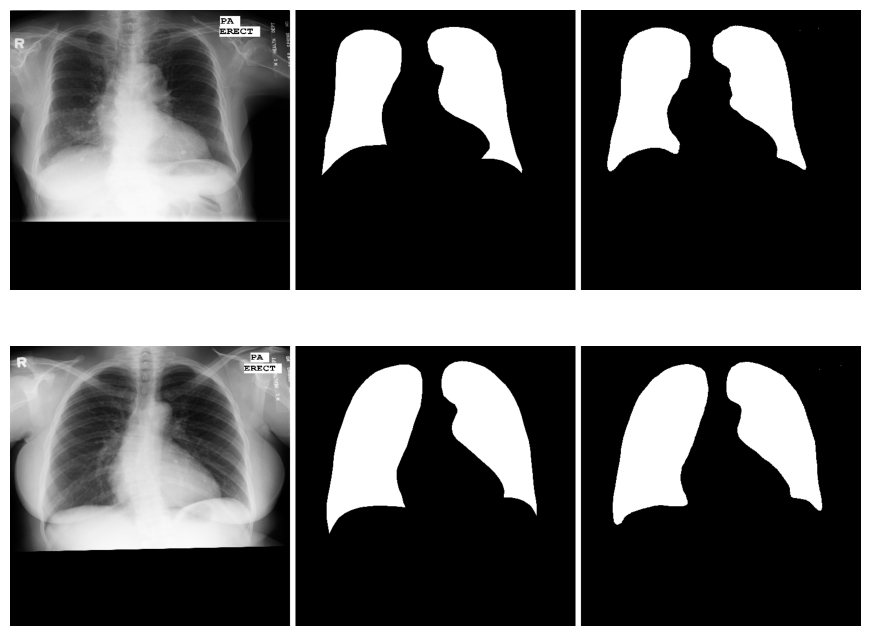

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path1 = '/content/drive/MyDrive/Image Segmentation/LungImageXRAY/results/MCUCXR_0117_1.png'
image_path2 = '/content/drive/MyDrive/Image Segmentation/LungImageXRAY/results/MCUCXR_0027_0.png'

# Read the image
img1 = mpimg.imread(image_path1)
img2 = mpimg.imread(image_path2)
# Display the image
plt.figure(figsize=[14,8])
# Subplot 1
plt.subplot(211)
plt.imshow(img1)
plt.axis('off')  # Turn off axis labels

# Subplot 2
plt.subplot(212)
plt.imshow(img2)
plt.axis('off')  # Turn off axis labels
plt.show()